In [1]:
import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import windrose
from windrose import WindroseAxes, plot_windrose


# plt.rcParams["font.sans-serif"] = ["Mona Sans", "Mona-Sans", "Hubot-Sans"]
mpl.rcParams["date.autoformatter.day"] = "%b %d\n%Y"
mpl.rcParams["date.autoformatter.hour"] = "%b %d\n%H:%M"
mpl.rcParams["figure.figsize"] = [10, 6]
mpl.rcParams["figure.dpi"] = 140
mpl.rcParams["axes.labelsize"] = "large"
mpl.rcParams["xtick.labelsize"] = "medium"
mpl.rcParams["ytick.labelsize"] = "medium"
mpl.rcParams["axes.titlesize"] = "xx-large"
mpl.rcParams["axes.facecolor"] = ".95"
mpl.rcParams["axes.spines.left"] = False
mpl.rcParams["axes.spines.bottom"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["xtick.major.size"] = 0
mpl.rcParams["xtick.minor.size"] = 0
mpl.rcParams["ytick.major.size"] = 0
mpl.rcParams["ytick.minor.size"] = 0


def spddir_to_uv(wspd, wdir, round=3):
    """Compute u and v wind components from wind speed and direction.

    https://earthscience.stackexchange.com/a/11989/18840

    NOTE: You could use MetPy; but dealing with units is slow.

    NOTE: Watch for components near zero caused by limitation of float precision of sin(180)

    Parameters
    ----------
    wspd, wdir : array_like
        Arrays of wind speed and wind direction (in degrees)

    Returns
    -------
    u and v wind components
    """
    if isinstance(wspd, list) or isinstance(wdir, list):
        wspd = np.array(wspd)
        wdir = np.array(wdir)

    wdir = np.deg2rad(wdir)

    u = -wspd * np.sin(wdir)
    v = -wspd * np.cos(wdir)

    if round:
        u = u.round(round)
        v = v.round(round)

    return u, v


In [62]:
station_selector = "WBB,UKBKB,KMRY,MTMET"
rose_var = "wind_speed"
variables = f"{rose_var},wind_direction"
units = "english"
obtimezone = "local"
token = "d25c2abe02b94001a82e7790d9c30f06"
start = pd.Timestamp("2023-07-01")
end = pd.Timestamp("2023-07-05")

base_url = "https://api.synopticdata.com/v2/stations/timeseries?"
arguments = [
    f"stid={station_selector}",
    f"start={start:%Y%m%d%H%M}",
    f"end={end:%Y%m%d%H%M}",
    f"vars={variables}",
    f"varsoperator=and",
    f"units={units}",
    f"obtimezone={obtimezone}",
    f"token={token}",
]
url = base_url + "&".join(arguments)
url


'https://api.synopticdata.com/v2/stations/timeseries?stid=WBB,UKBKB,KMRY,MTMET&start=202307010000&end=202307050000&vars=wind_speed,wind_direction&varsoperator=and&units=english&obtimezone=local&token=d25c2abe02b94001a82e7790d9c30f06'

In [ ]:
data = json.loads(requests.get(url).text)

Z = {}
for stn in data["STATION"]:
    obs = stn.pop("OBSERVATIONS")
    senvars = stn.pop("SENSOR_VARIABLES")

    # Turn station observations into a DataFrame
    df = pd.DataFrame(obs).set_index("date_time")

    # Remaining data in dict will be returned as attribute
    df.attrs = stn

    # Convert datetime index string to datetime
    if obtimezone.lower() == "local":
        # Drop timezone info to preserve local time
        df.index = pd.to_datetime(df.index).tz_localize(None)
    else:
        df.index = pd.to_datetime(df.index)

    # Sort column order alphabetically
    df = df.reindex(columns=df.columns.sort_values())

    # In the DataFrame attributes, Convert some strings to float/int
    # (i.e., ELEVATION, latitude, longitude) BUT NOT STID
    # because some STIDs could be all numeric characters.
    for k, v in df.attrs.items():
        if isinstance(v, str) and k not in ["STID"]:
            try:
                n = float(v)
                if n.is_integer():
                    df.attrs[k] = int(n)
                else:
                    df.attrs[k] = n
            except:
                pass

    # Include other info
    for i in data.keys():
        if i != "STATION":
            df.attrs[i] = data[i]
    df.attrs["SENSOR_VARIABLES"] = senvars
    df.attrs["service"] = "stations_timeseries"
    df.attrs = dict(sorted(df.attrs.items()))

    # Insert dataframe in Z dictionary
    Z[df.attrs["STID"]] = df

In [ ]:
Z.keys()

dict_keys(['WBB', 'KMRY', 'MTMET', 'UKBKB'])

In [61]:
# Since each station could have multiple sets, I will make a new
# dataframe for each unique set for each station
df_dict = {}
for stid, df in Z.items():
    unique_sets = {"_".join(i[-2:]) for i in df.columns.str.rsplit("_", n=2)}

    # For each set, make a windrose axes
    for s in unique_sets:
        _df = df.filter(regex=s)
        _df = _df.rename(
            columns={f"{rose_var}_{s}": "speed", f"wind_direction_{s}": "direction"}
        )
        df_dict[f"{stid}_{s}"] = _df

if rose_var == "wind_speed":
    # Beaufort Scale (knots) >> https://en.wikipedia.org/wiki/Beaufort_scale
    bins = np.array([0, 1, 4, 7, 11, 17, 22, 28, 34, 41, 48, 56, 64], dtype=float)
    if units == "metric":
        bins /= 1.9438
        bins = np.ceil(bins)
    cmap = mpl.cm.OrRd
elif rose_var == "ozone_concentration":
    bins = [0, 60, 75, 95, 115]
    cmap = mpl.cm.Blues
elif rose_var == "pm25_concentration":
    bins = [0, 12.1, 35, 55.4, 150.4]
    cmap = mpl.cm.Blues

for stid_set, _df in df_dict.items():
    plt.figure()
    ax = plot_windrose(
        _df,
        kind="bar",
        normed=True,
        opening=0.85,
        edgecolor=".2",
        linewidth=0.3,
        # TODO: Bin by Beaufort Scale >> https://en.wikipedia.org/wiki/Beaufort_scale
        bins=bins,
        cmap=cmap,
    )
    set_type = stid_set.split("_")[-1]
    label = stid_set.split("_")[0]
    if set_type[0] != "1":
        # indicate this is the nth dataset
        label += "$^{" + set_type[0] + "}$"
    if set_type.endswith("d"):
        # indicate this is a derived value
        label += "$^{*}$"
    ax.yaxis.grid(True, color="w", linewidth=1, zorder=-100000, linestyle="--")
    ax.xaxis.grid(False)
    leg = ax.legend(
        loc="center left",
        title=f'{rose_var.replace("_"," ").title()} ({_df.attrs["UNITS"][rose_var]})',
        bbox_to_anchor=(1.1, 0.8),
        fontsize=12,
    )
    leg.draw_frame(False)
    ax.tick_params(axis="x", labelsize=15)
    ax.set_yticks(np.arange(0, 105, 10))
    ax.set_yticklabels(
        [
            "",
            "10%",
            "20%",
            "30%",
            "40%",
            "50%",
            "60%",
            "70%",
            "80%",
            "90%",
            "100%",
        ],
        fontsize=10,
        alpha=0.5,
    )
    table = ax._info["table"]
    wd_freq = np.sum(table, axis=0)
    ax.set_rmax(
        np.floor(max(wd_freq) / 10) * 10 + 10
    )  # set rmax to upper number divisible by 5

    text = (
        ""
        + f"  Station : {label}\n"
        + f" Variable : {rose_var}\n"
        + f"    Units : {_df.attrs['UNITS'][rose_var]}\n"
        + f"  Samples : {len(_df):,}\n"
        + f"    Start : {_df.index.min():%Y-%m-%d %H:%M}\n"
        + f"      End : {_df.index.max():%Y-%m-%d %H:%M}\n"
        + f" Timezone : {obtimezone}\n"
        + f"Smoothing : {None}"
    )

    plt.figtext(
        0.9,
        0.1,
        text,
        fontname="monospace",
        va="bottom",
        backgroundcolor="white",
        fontsize=12,
    )

TypeError: only length-1 arrays can be converted to Python scalars

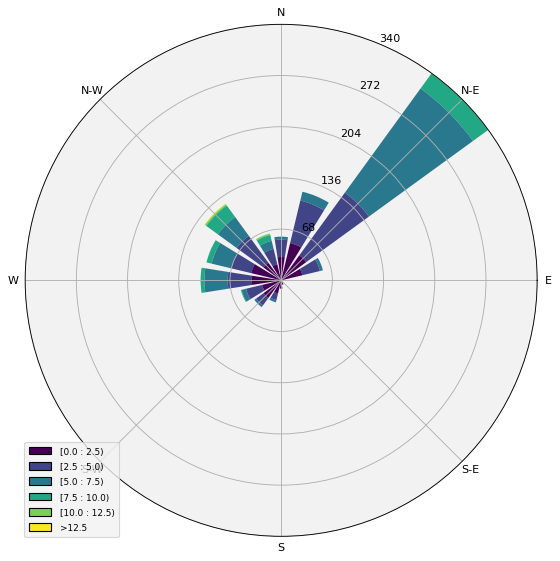

In [180]:
ax = plot_windrose(a, kind="bar")

ax.set_zorder(2000000)

# for axis in ax.axes._get_axis_list():
#     axis.set_zorder(-2000)

# for i in ax.patches_list:
#     i.set_zorder(1000000)
#     print(i.get_zorder())

# ax.stale = True


In [176]:
ax.axes


<WindroseAxes: >

In [177]:
ax


<WindroseAxes: >

In [154]:
for i in ax.patches_list:
    i.set_zorder(-2000)


In [162]:
ax.ArtistList.count(ax)


TypeError: Sequence.count() missing 1 required positional argument: 'value'

In [119]:
ax.set_zorder(1000000)

AttributeError: 'WindroseAxes' object has no attribute '_get_axis_list'

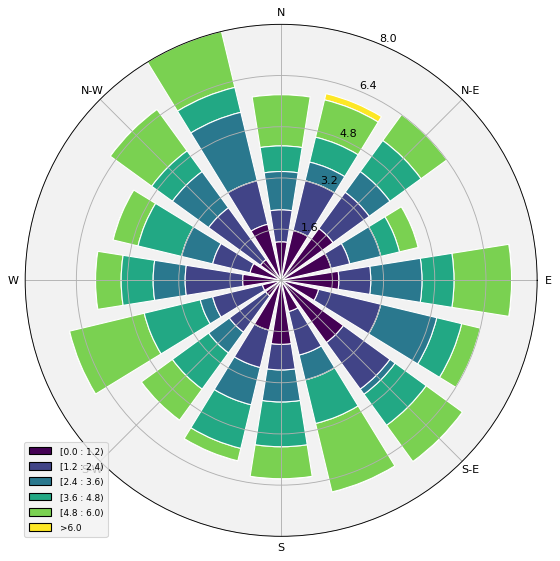

In [183]:
import numpy as np

N = 500
ws = np.random.random(N) * 6
wd = np.random.random(N) * 360

from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor="white")
ax.set_legend()

for axis in ax._get_axis_list():
    axis.set_zorder(-2000)  # or every thing lower than -1000